In [2]:
%run import_modules.py
%matplotlib inline

In [3]:
import shap
import joblib
from tqdm import tqdm_notebook
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from bayes_opt import BayesianOptimization
from vecstack import StackingTransformer

In [4]:
df_train = pd.read_csv('X_train.csv', encoding='cp949')
df_test = pd.read_csv('X_test.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv').gender
IDtest = df_test.cust_id.unique()

In [5]:
def pivot_maker(df_train, df_test, level) :
    
    pivot = pd.pivot_table(pd.concat([df_train, df_test]), index='cust_id', columns=level, values='amount',
                            aggfunc=lambda x: len(x), fill_value=0).reset_index()
    
    if pivot.shape[0] != 5982:
        
        temp = pd.DataFrame({'cust_id':range(5982)})
        pivot = pd.merge(temp, pivot, how = 'outer', on ='cust_id').fillna(0)

    return pivot

def pre_processing(df):
        
        df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0) 
        df.iloc[:,1:] = np.log1p(df.iloc[:,1:]) 
        
        return df

def pca_processing(df):
    
    max_d = num_d = df.shape[1] - 1
    pca = PCA(n_components=max_d, random_state=0).fit(df.iloc[:,1:])
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    num_d = np.argmax(cumsum >= 0.99) + 1
    
    if num_d == 1: 
        
        num_d = max_d
        
    pca = PCA(n_components=num_d, random_state=0).fit_transform(df.iloc[:,1:])
    df = pd.concat([df.iloc[:,0], pd.DataFrame(pca)], axis=1)
    
    return df

def train_test_x(df):
    
    train = df.query('cust_id not in @IDtest').drop('cust_id', axis=1)
    test = df.query('cust_id in @IDtest').drop('cust_id', axis=1)
    
    return train, test

def shap_select(train_x, test_x):
    
    X_importance = test_x
    model = XGBClassifier(random_state=0).fit(train_x, y_train)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_importance)
    
    shap.summary_plot(shap_values, X_importance)
    shap.summary_plot(shap_values, X_importance, plot_type='bar')
    
    shap_sum = np.abs(shap_values).mean(axis=0)
    importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
    importance_df.columns = ['column_name', 'shap_importance']
    importance_df = importance_df.sort_values('shap_importance', ascending=False)
    display(importance_df)
    return importance_df

def feature_selectp(train_x, y_train, importance_df):
    
    model = LogisticRegression(random_state=0)
    
    cv_scores = []
    sscv = ShuffleSplit(n_splits = 5, random_state = 0)
    for p in tqdm(range(5,100,1)):
        
        nf = int(importance_df.shape[0] * p * 0.01)
        features_selected = importance_df.iloc[:nf].column_name
        X_new = train_x[features_selected]
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=sscv).mean()
        cv_scores.append((p,cv_score))
        
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(best_score)
    
    plt.plot([k for k, _ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.grid()
    
    return best_score

def X_train_test_sel(train_x, test_x,importance_df,best_score):
    
    nf = int(importance_df.shape[0] * best_score[0] * 0.01)
    features_selected = importance_df.iloc[:nf].column_name
    X_train_sel = train_x[features_selected]
    X_test_sel = X_test_sel = test_x[features_selected]

    return X_train_sel, X_test_sel

In [6]:
def data_processing(pivot_table):

    df = pca_processing(pre_processing(pivot_table))

    train_x, test_x = train_test_x(df)
    
    return train_x, test_x

def multi_concat(train_x_1, test_x_1, train_x_2, test_x_2):
    
    train_x = pd.concat([train_x_1, train_x_2], axis = 1, ignore_index=True)
    test_x =  pd.concat([test_x_1, test_x_2], axis = 1, ignore_index=True)
    
    return train_x, test_x

def feature_engineering(train_x, test_x, y_train):

    importance_df = shap_select(train_x, test_x)

    best_score = feature_selectp(train_x, y_train, importance_df)

    return X_train_test_sel(train_x, test_x,importance_df,best_score)

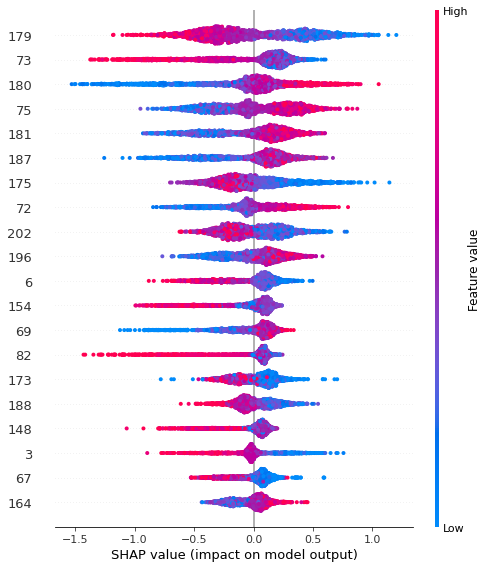

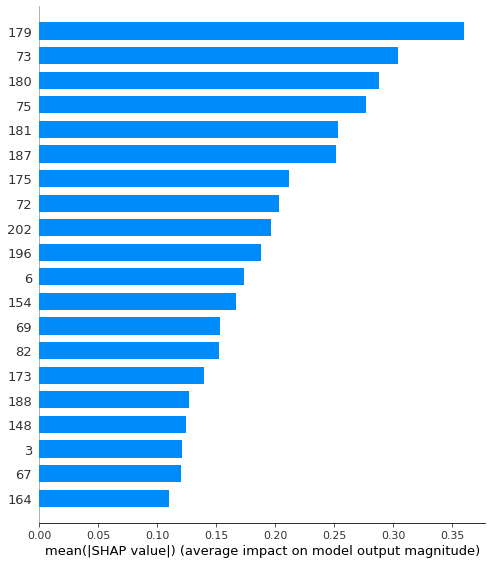

,column_name,shap_importance
179,179.0,0.360268
73,73.0,0.304269
180,180.0,0.287740
75,75.0,0.277119
181,181.0,0.253027
...,...,...
157,157.0,0.009756
18,18.0,0.009496
7,7.0,0.004665
57,57.0,0.003870


100%|██████████████████████████████████████████████████████████████████████████████████| 95/95 [00:22<00:00,  4.14it/s]

(21, 0.7732189932840449)
Wall time: 37.8 s


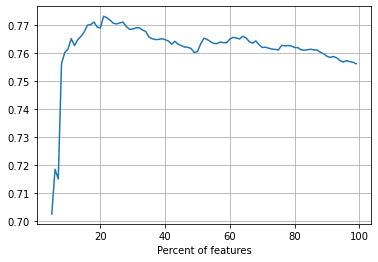

In [8]:
%%time

goods_table = pd.pivot_table(pd.concat([df_train, df_test]), index = 'cust_id', columns='goods_id', values='amount',
                       aggfunc=lambda x: len(x), fill_value=0).reset_index()

goods_table = goods_table.iloc[:,1:]

target_list = np.array(goods_table.sum(axis = 0).sort_values(axis =0, ascending = False)[:700].index)

df_train_good = df_train.query('goods_id in @target_list')
df_test_good = df_test.query('goods_id in @target_list')

train_x_1, test_x_1 = data_processing(pivot_maker(df_train, df_test, 'gds_grp_nm'))
train_x_2, test_x_2 = data_processing(pd.merge(pivot_maker(df_train, df_test, 'gds_grp_mclas_nm'), pivot_maker(df_train, df_test, 'store_nm'), on = 'cust_id'))
train_x_3, test_x_3 = data_processing(pivot_maker(df_train_good, df_test_good, 'goods_id'))

train_x_4, test_x_4 = multi_concat(train_x_1, test_x_1, train_x_2, test_x_2)
train_x, test_x = multi_concat(train_x_3, test_x_3, train_x_4, test_x_4)

X_train_sel, X_test_sel = feature_engineering(train_x, test_x, y_train)

In [10]:
bow_data = {
    
    'X_train_bow_sel': X_train_sel, 
    'X_test_bow_sel': X_test_sel,
    'y_train': y_train,
    'IDtest' : IDtest
}

joblib.dump(bow_data, 'bow_data.pkl')

['bow_data.pkl']